In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from comparers import ModelComparer
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import classification_report
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity, print_complexity
from surrogate_tree import train_surrogate_tree, tree_to_rules, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, constraint_matrix_to_rules, extract_rules, print_rules,\
                 evaluate

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
with open('ground_truth.(False, True).pickle', 'rb') as f:
    ground_truth_instance_indices_01, ground_truth_01 = pickle.load(f)
with open('ground_truth.(True, False).pickle', 'rb') as f:
    ground_truth_instance_indices_10, ground_truth_10 = pickle.load(f)

## Tree with Depth 2

In [6]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=2)

CPU times: user 2.18 ms, sys: 405 µs, total: 2.58 ms
Wall time: 7.02 ms


In [7]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.91      0.98      0.95       784
 (False, True)       0.00      0.00      0.00        12
  (True, True)       0.89      0.65      0.75       181

      accuracy                           0.91       977
     macro avg       0.60      0.54      0.57       977
  weighted avg       0.90      0.91      0.90       977



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Tree with Depth 3

In [8]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=3)

CPU times: user 2.92 ms, sys: 1.89 ms, total: 4.81 ms
Wall time: 3.38 ms


In [9]:
evaluate(model, X, mclass_diff, comparer.class_names)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                precision    recall  f1-score   support

(False, False)       0.93      0.99      0.96       784
 (False, True)       0.00      0.00      0.00        12
  (True, True)       0.96      0.72      0.82       181

      accuracy                           0.93       977
     macro avg       0.63      0.57      0.59       977
  weighted avg       0.92      0.93      0.92       977



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Tree with Depth 4

In [10]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=4)

CPU times: user 3.32 ms, sys: 1.76 ms, total: 5.08 ms
Wall time: 12.4 ms


In [11]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.93      0.99      0.96       784
 (False, True)       0.50      0.08      0.14        12
  (True, True)       0.94      0.73      0.83       181

      accuracy                           0.93       977
     macro avg       0.79      0.60      0.64       977
  weighted avg       0.93      0.93      0.93       977



## Tree with Depth 5

In [12]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=5)

CPU times: user 3.41 ms, sys: 1.89 ms, total: 5.3 ms
Wall time: 4.95 ms


In [13]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.94      0.99      0.97       784
 (False, True)       1.00      0.17      0.29        12
  (True, True)       0.95      0.78      0.85       181

      accuracy                           0.94       977
     macro avg       0.96      0.65      0.70       977
  weighted avg       0.94      0.94      0.94       977



## Tree with Depth 6

In [14]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=6)

CPU times: user 2.84 ms, sys: 375 µs, total: 3.21 ms
Wall time: 2.87 ms


In [15]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.98      0.98      0.98       784
 (False, True)       1.00      0.25      0.40        12
  (True, True)       0.88      0.94      0.91       181

      accuracy                           0.96       977
     macro avg       0.95      0.72      0.76       977
  weighted avg       0.96      0.96      0.96       977



## Tree with Depth 7

In [16]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=7)

CPU times: user 4.35 ms, sys: 1.55 ms, total: 5.9 ms
Wall time: 8.45 ms


In [17]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.99      0.98      0.99       784
 (False, True)       1.00      0.25      0.40        12
  (True, True)       0.90      0.96      0.93       181

      accuracy                           0.97       977
     macro avg       0.96      0.73      0.77       977
  weighted avg       0.97      0.97      0.97       977



## Tree with Depth 8

In [18]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=8)

CPU times: user 3.87 ms, sys: 1.92 ms, total: 5.79 ms
Wall time: 7.11 ms


In [19]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.99      0.98      0.99       784
 (False, True)       0.73      0.67      0.70        12
  (True, True)       0.93      0.95      0.94       181

      accuracy                           0.97       977
     macro avg       0.88      0.87      0.87       977
  weighted avg       0.97      0.97      0.97       977



## Tree with Depth 9

In [20]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=9)

CPU times: user 3.32 ms, sys: 583 µs, total: 3.9 ms
Wall time: 5.18 ms


In [21]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.99      0.99      0.99       784
 (False, True)       1.00      0.67      0.80        12
  (True, True)       0.96      0.97      0.96       181

      accuracy                           0.98       977
     macro avg       0.98      0.88      0.92       977
  weighted avg       0.98      0.98      0.98       977



## Tree with Depth 10

In [22]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=10)

CPU times: user 4.2 ms, sys: 2.41 ms, total: 6.61 ms
Wall time: 12.1 ms


In [23]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      0.99      1.00       784
 (False, True)       1.00      0.75      0.86        12
  (True, True)       0.96      0.99      0.98       181

      accuracy                           0.99       977
     macro avg       0.99      0.91      0.94       977
  weighted avg       0.99      0.99      0.99       977



## Tree with Depth 11

In [24]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=11)

CPU times: user 4.2 ms, sys: 1.78 ms, total: 5.98 ms
Wall time: 10.1 ms


In [25]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       784
 (False, True)       1.00      0.75      0.86        12
  (True, True)       0.98      0.99      0.99       181

      accuracy                           0.99       977
     macro avg       0.99      0.91      0.95       977
  weighted avg       0.99      0.99      0.99       977



## Tree with Depth 12

In [26]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=12)

CPU times: user 4.15 ms, sys: 1.83 ms, total: 5.98 ms
Wall time: 6.93 ms


In [27]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       784
 (False, True)       0.92      1.00      0.96        12
  (True, True)       1.00      0.99      1.00       181

      accuracy                           1.00       977
     macro avg       0.97      1.00      0.99       977
  weighted avg       1.00      1.00      1.00       977



## Tree with Depth 13

In [28]:
%%time
model = train_surrogate_tree(X, mclass_diff, max_depth=13)

CPU times: user 3.59 ms, sys: 1.35 ms, total: 4.94 ms
Wall time: 4.63 ms


In [29]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       784
 (False, True)       1.00      1.00      1.00        12
  (True, True)       1.00      1.00      1.00       181

      accuracy                           1.00       977
     macro avg       1.00      1.00      1.00       977
  weighted avg       1.00      1.00      1.00       977



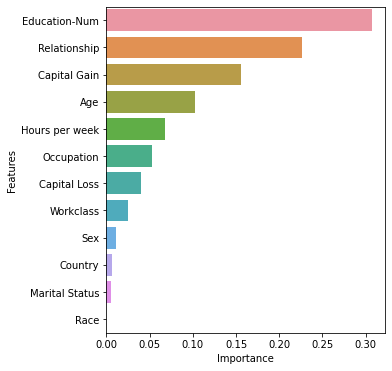

In [30]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5,6))

In [31]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. Age > 59.0 and 9.5 < `Education-Num` <= 12.5 and Occupation <= 13.5 and Relationship > 3.5 and `Capital Gain` <= 5095.5 and 37.5 < `Hours per week` <= 42.5 => (False, True) [0, 3, 0]
2. 42.5 < Age <= 59.0 and 2.5 < Workclass <= 5.5 and 9.5 < `Education-Num` <= 12.5 and Occupation <= 3.5 and Relationship > 3.5 and `Capital Gain` <= 5095.5 and 37.5 < `Hours per week` <= 41.5 => (False, True) [0, 2, 0]
3. 36.5 < Age <= 37.5 and `Education-Num` > 12.5 and Occupation > 5.5 and Relationship > 3.5 and 31.0 < `Hours per week` <= 50.0 and Country > 14.0 => (False, True) [0, 1, 0]
4. 27.0 < Age <= 31.5 and `Education-Num` > 13.5 and Occupation > 3.5 and Relationship > 3.5 => (False, True) [0, 1, 0]
5. 27.0 < Age <= 31.5 and 12.5 < `Education-Num` <= 13.5 and 6.0 < Occupation <= 9.0 and Relationship > 3.5 => (False, True) [0, 1, 0]
6. 46.5 < Age <= 50.5 and Workclass > 4.5 and `Education-Num` <= 9.5 and Relationship > 3.5 and `Capital Gain` <= 2878.0 and `Capital Loss` <= 1779.5 and `Hours per

### Evaluation

In [32]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(False, True)')[0]]

In [33]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(False, True)')[0]]

#### Global Fidelity

In [34]:
evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       784
 (False, True)       1.00      1.00      1.00        12
  (True, True)       1.00      1.00      1.00       181

      accuracy                           1.00       977
     macro avg       1.00      1.00      1.00       977
  weighted avg       1.00      1.00      1.00       977



#### Counterfactual Fidelity Error

In [36]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01, ground_truth_01, instance_indices_per_rule_01, constraints_01)

invalid value encountered in true_divide


In [37]:
rmse

Age                  8.240859
Workclass            1.707825
Education-Num        0.500000
Marital Status            NaN
Occupation           5.632697
Relationship         1.500000
Race                      NaN
Sex                       NaN
Capital Gain      4142.025308
Capital Loss      1048.500000
Hours per week       5.529144
Country             12.000000
dtype: float64

In [38]:
boundary_miss_rate

Age               0.291667
Workclass         0.700000
Education-Num     0.260870
Marital Status    1.000000
Occupation        0.521739
Relationship      0.368421
Race              1.000000
Sex               1.000000
Capital Gain      0.230769
Capital Loss      0.833333
Hours per week    0.416667
Country           0.909091
dtype: float64

In [39]:
boundary_add_rate

Age               0.000000
Workclass         0.142857
Education-Num     0.000000
Marital Status    1.000000
Occupation        0.000000
Relationship      0.000000
Race                   NaN
Sex                    NaN
Capital Gain      0.000000
Capital Loss      0.000000
Hours per week    0.000000
Country           0.000000
dtype: float64

In [40]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
701 lower  24.0        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            0.5             NaN        10.5   
948 lower  16.0        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            0.5             NaN        10.5   
961 lower  -2.0        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            0.5             NaN         9.5   
64  lower  -0.5        1.5            0.5             NaN         NaN   
    upper  -2.0        0.5            0.5             NaN         0.5   
406 lower  -0.5        1.5            0.5             NaN         NaN   
    upper  -2.0        0.5            0.5             NaN         0.5   
70  lower   3.5        NaN            0.5             NaN         1.5   
    upper  -5.5        NaN            NaN             NaN         NaN   
883 lower   0.0        NaN            0.5             NaN        -5.5   
    upper   2.5        NaN            NaN             NaN         NaN   
925 lower  -2.0        NaN            0.5             NaN         2.0   
    upper  -3.5        NaN           -0.5             NaN         0.0   
484 lower   3.5        3.5            NaN             NaN         NaN   
    upper -10.5        NaN            0.5             NaN         NaN   
744 lower   3.5        NaN            NaN             NaN         0.5   
    upper -10.5       -0.5            0.5             NaN         1.0   
558 lower   NaN        NaN            NaN             NaN         NaN   
    upper   NaN        NaN            NaN             NaN         NaN   
531 lower   NaN        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            NaN             NaN         NaN   

           Relationship  Race  Sex  Capital Gain  Capital Loss  \
701 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
948 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
961 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
64  lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
406 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
70  lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN           NaN           NaN   
883 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN           NaN           NaN   
925 lower          -0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN           NaN           NaN   
484 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        2822.0        1048.5   
744 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        2822.0        1048.5   
558 lower           NaN   NaN  NaN        1357.0           NaN   
    upper           3.5   NaN  NaN         658.5           NaN   
531 lower           NaN   NaN  NaN           NaN           NaN   
    upper           3.5   NaN  NaN        5136.0           NaN   

           Hours per week  Country  
701 lower            -1.5      NaN  
    upper             1.5      NaN  
948 lower            -1.5      NaN  
    upper             1.5      NaN  
961 lower            -1.5      NaN  
    upper             1.5      NaN  
64  lower            -1.5      NaN  
    upper             0.5      NaN  
406 lower            -1.5      NaN  
    upper             0.5      NaN  
70  lower            -8.0     12.0  
    upper             9.0      NaN  
883 lower             NaN      NaN  
    upper        

In [41]:
RuleClassifier(feature_names, rules).apply(X[[484], :])

array([6])

In [42]:
rules[6-1]

'46.5 < Age <= 50.5 and Workclass > 4.5 and `Education-Num` <= 9.5 and Relationship > 3.5 and `Capital Gain` <= 2878.0 and `Capital Loss` <= 1779.5 and `Hours per week` <= 52.5'

In [43]:
X_test = X[[484], :]
comparer.class_names[comparer.predict_mclass_diff(X_test)]

array(['(False, True)'], dtype='<U14')

In [44]:
X_test[:, comparer.check_feature('Hours per week')[0]]

array([40.])

In [45]:
X_test[:, comparer.check_feature('Hours per week')[0]] = 45
comparer.class_names[comparer.predict_mclass_diff(X_test)]

array(['(True, True)'], dtype='<U14')

#### Complexity

In [46]:
print_complexity(constraints_01)

Number of rules: 9
Number of constraints: 65 (7.2 per rule)


#### Stability

Saving results for comparison in baseline.test notebook

In [47]:
with open('explanation-baseline-orig.pickle', 'wb') as f:
    pickle.dump((constraints_01, instance_indices_per_rule_01), f)

# Summary

## Global Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
01/global | - | - | -
01/local | 100\% | 100\% | 100\%

## Counterfactual Fidelity Error

Ruleset | RMSE | boundaries missed | unnecessary boundaries
 --- | --- | --- | ---
01/global | - | - | -
01/local | 1374 | 55\% | 1.1\%

## Complexity

Ruleset | # Rules | # Constraints
 --- | --- | ---
01/global | - | -
01/local | 9 | 65

## Generation Time

<1s